In [7]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [66]:
from data import load
inputs, outputs, reference = load('bec1d.data')

Get 50 samples from 512 data points

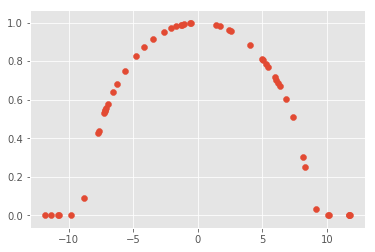

In [27]:
idx = torch.randint(0, 512, (50,))
train_x = torch.tensor(reference['x'][idx]).float()
train_y = torch.tensor(outputs[0][idx]).float()
plt.scatter(train_x.data.numpy(), train_y.data.numpy())

- BEC tensor

In [364]:
N = 50000
x_size = 512

g = torch.tensor(inputs).float()
x = torch.tensor(reference['x']).float()
y = torch.tensor(outputs).float()

gx = torch.stack(
    [g.view(1, -1).repeat(x_size, 1).t(), x.repeat(N, 1)]
).permute(1, 0, 2)

In [187]:
gxy = torch.cat([gx, y.view(N, 1, -1)], dim=1)

In [326]:
M = 1000
gxy_tensor_short = gxy.permute(1, 0, 2)[:M].contiguous().view(3, -1).t()
gx_samples = gxy_tensor_short[torch.randint(0, gxy_tensor_short.size(0), (M,))]

In [327]:
X = gx_samples[:, :2]
y = gx_samples[:, -1]

In [328]:
X.size(), y.size()

(torch.Size([1000, 2]), torch.Size([1000]))

## 2D Gaussian

In [5]:
import numpy as np

In [329]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)

gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=[5, 5]),
             n_restarts_optimizer=15, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

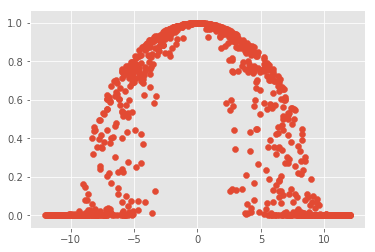

In [330]:
plt.scatter(X[:, 1].data.numpy(), gp.predict(X))

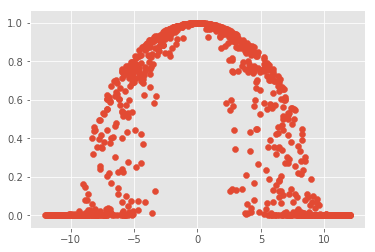

In [331]:
plt.scatter(X[:, 1].data.numpy(), y)

In [333]:
y_pred, sigma = gp.predict(X, return_std=True)

/usr/local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [349]:
X_np = X.data.numpy()[:100]
y_np = y.data.numpy()[:100]

In [347]:
X_np[:, 1]

array([ -3.5859375, -10.4765625,  -1.6640625,  -3.8203125,   6.4453125,
         5.8359375,   1.4296875,  -3.7734375,   9.3515625,   1.0078125,
         1.8046875,  -2.7890625,  11.3671875, -11.5078125, -11.1328125,
         1.8984375,  -4.0078125,   3.3046875,  -4.8046875,   7.7109375,
        10.6171875,  11.9296875,  -4.6640625,  -8.2265625, -11.6953125,
         2.8359375,   5.5546875,  -1.0078125,  -0.6796875,  11.4140625,
         3.8203125,  -7.6640625,  -4.2421875,  -8.1796875,  10.8515625,
        11.6484375,   7.8515625,   9.5390625,  -3.3984375,  -5.9296875,
        -5.7890625,   8.5078125,   8.7421875,  -8.7890625, -11.0859375,
        -8.6484375,   3.5859375,   4.1953125,  -6.3515625,   1.8515625,
        -1.9453125,   8.1796875, -10.3828125,   9.6328125, -11.6484375,
         6.9140625,  11.6484375,  -6.2578125,  -4.8984375,   5.7890625,
         9.5859375,  -8.4609375, -10.4765625,   4.4765625,   8.7421875,
       -11.2265625,   9.5390625, -10.7578125,   4.1484375,  11.9

## Prediction

In [368]:
y[idx]

torch.Size([50000, 512])

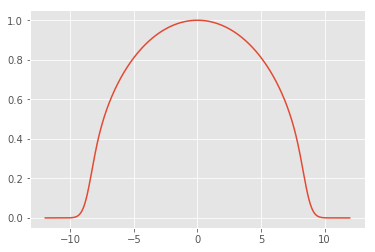

In [405]:
idx = torch.randint(0, 512, (50,))
g_pred = g[0]
x_pred = reference['x']
y_pred = y[0]
def to_np(t): return t.data.numpy()
def to_to(a): return torch.tensor(a).float()
plt.plot(x_pred, to_np(y_pred))

In [376]:
g_pred.repeat(512).size(), to_to(x_pred).size()

(torch.Size([512]), torch.Size([512]))

In [386]:
gx_pred = torch.stack([g_pred.repeat(512), to_to(x_pred)])  # .view(1, 2, 512)

In [389]:
to_np(gx_pred).shape

(2, 512)

In [388]:
X.shape

torch.Size([1000, 2])

In [391]:
y_hat_pred = gp.predict(to_np(gx_pred).transpose())

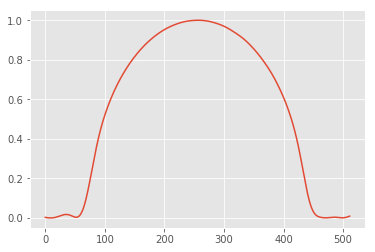

In [392]:
plt.plot(y_hat_pred)

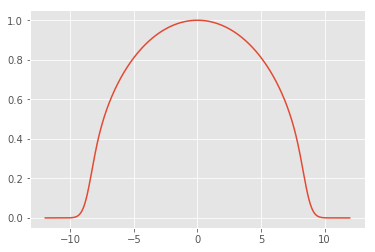

In [394]:
plt.plot(x_pred, to_np(y_pred))

## Confidence Plot

In [407]:
x_pred.shape, y_pred.shape

((512,), torch.Size([512]))

In [417]:
gx_pred

tensor([[398.8654, 398.8654, 398.8654,  ..., 398.8654, 398.8654, 398.8654],
        [-11.9766, -11.9297, -11.8828,  ...,  11.8828,  11.9297,  11.9766]])

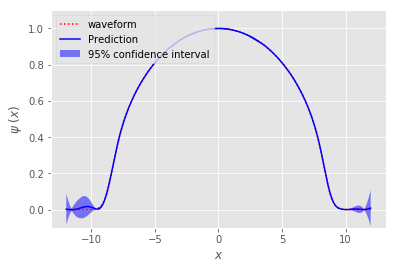

In [419]:
y_hat_pred, sigma = gp.predict(to_np(gx_pred).transpose(), return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x_pred, to_np(y_pred), 'r:', label='waveform')
# plt.plot(x_pred, y_pred, 'r.', markersize=10, label='Observations')
plt.plot(x_pred, y_hat_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([y_hat_pred - 1.9600 * sigma,
                        (y_hat_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$\psi\ (x)$')
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper left')
plt.savefig('gp_on_bec.png')